# Step 1: Dataset Loading, Splitting, and Exploration

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import collections

# Constants
WIDTH = 224
HEIGHT = 224
EPOCHS = 10

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((WIDTH, HEIGHT)),  # Resizing all images
    transforms.ToTensor(),          # Converting images to PyTorch tensors
])

# Load the dataset
data_dir = './Dataset'
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

# Split the dataset into train and test (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader for both sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check if CUDA is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Explore dataset: Display category names
class_names = dataset.classes
print(f"Classes: {class_names}")
print(f"Total images: {len(dataset)}")
print(f"Training set size: {train_size}, Test set size: {test_size}")

Using device: cuda
Classes: ['Asian Green Bee-Eater', 'Brown-Headed Barbet', 'Cattle Egret', 'Common Kingfisher', 'Common Myna', 'Common Rosefinch']
Total images: 5535
Training set size: 4428, Test set size: 1107


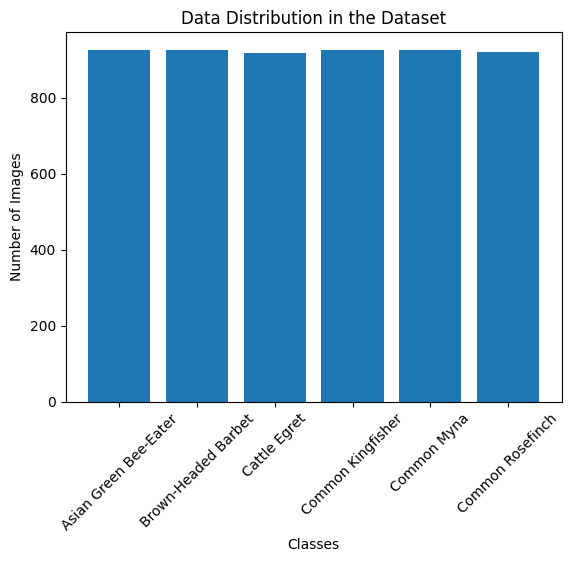

In [2]:
def display_data_distribution(dataset):
    class_counts = collections.Counter([label for _, label in dataset])
    class_names = dataset.classes
    counts = [class_counts[i] for i in range(len(class_names))]
    
    plt.bar(class_names, counts)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Data Distribution in the Dataset')
    plt.xticks(rotation=45)
    plt.show()

# Call function to display data distribution
display_data_distribution(dataset)

In [3]:
def print_image_dimension(dataset):
    # Load one image (before transformations)
    image_path = dataset.imgs[0][0]  # Get the path of the first image
    image = Image.open(image_path)
    
    # Print image size (width, height)
    print(f"Original image dimension: {image.size}")
    
    # Print transformed image size (after transformation)
    transformed_image = transform(image)
    print(f"Transformed image shape (C, H, W): {transformed_image.shape}")

# Call function to print image dimension
print_image_dimension(dataset)

Original image dimension: (1200, 888)
Transformed image shape (C, H, W): torch.Size([3, 224, 224])


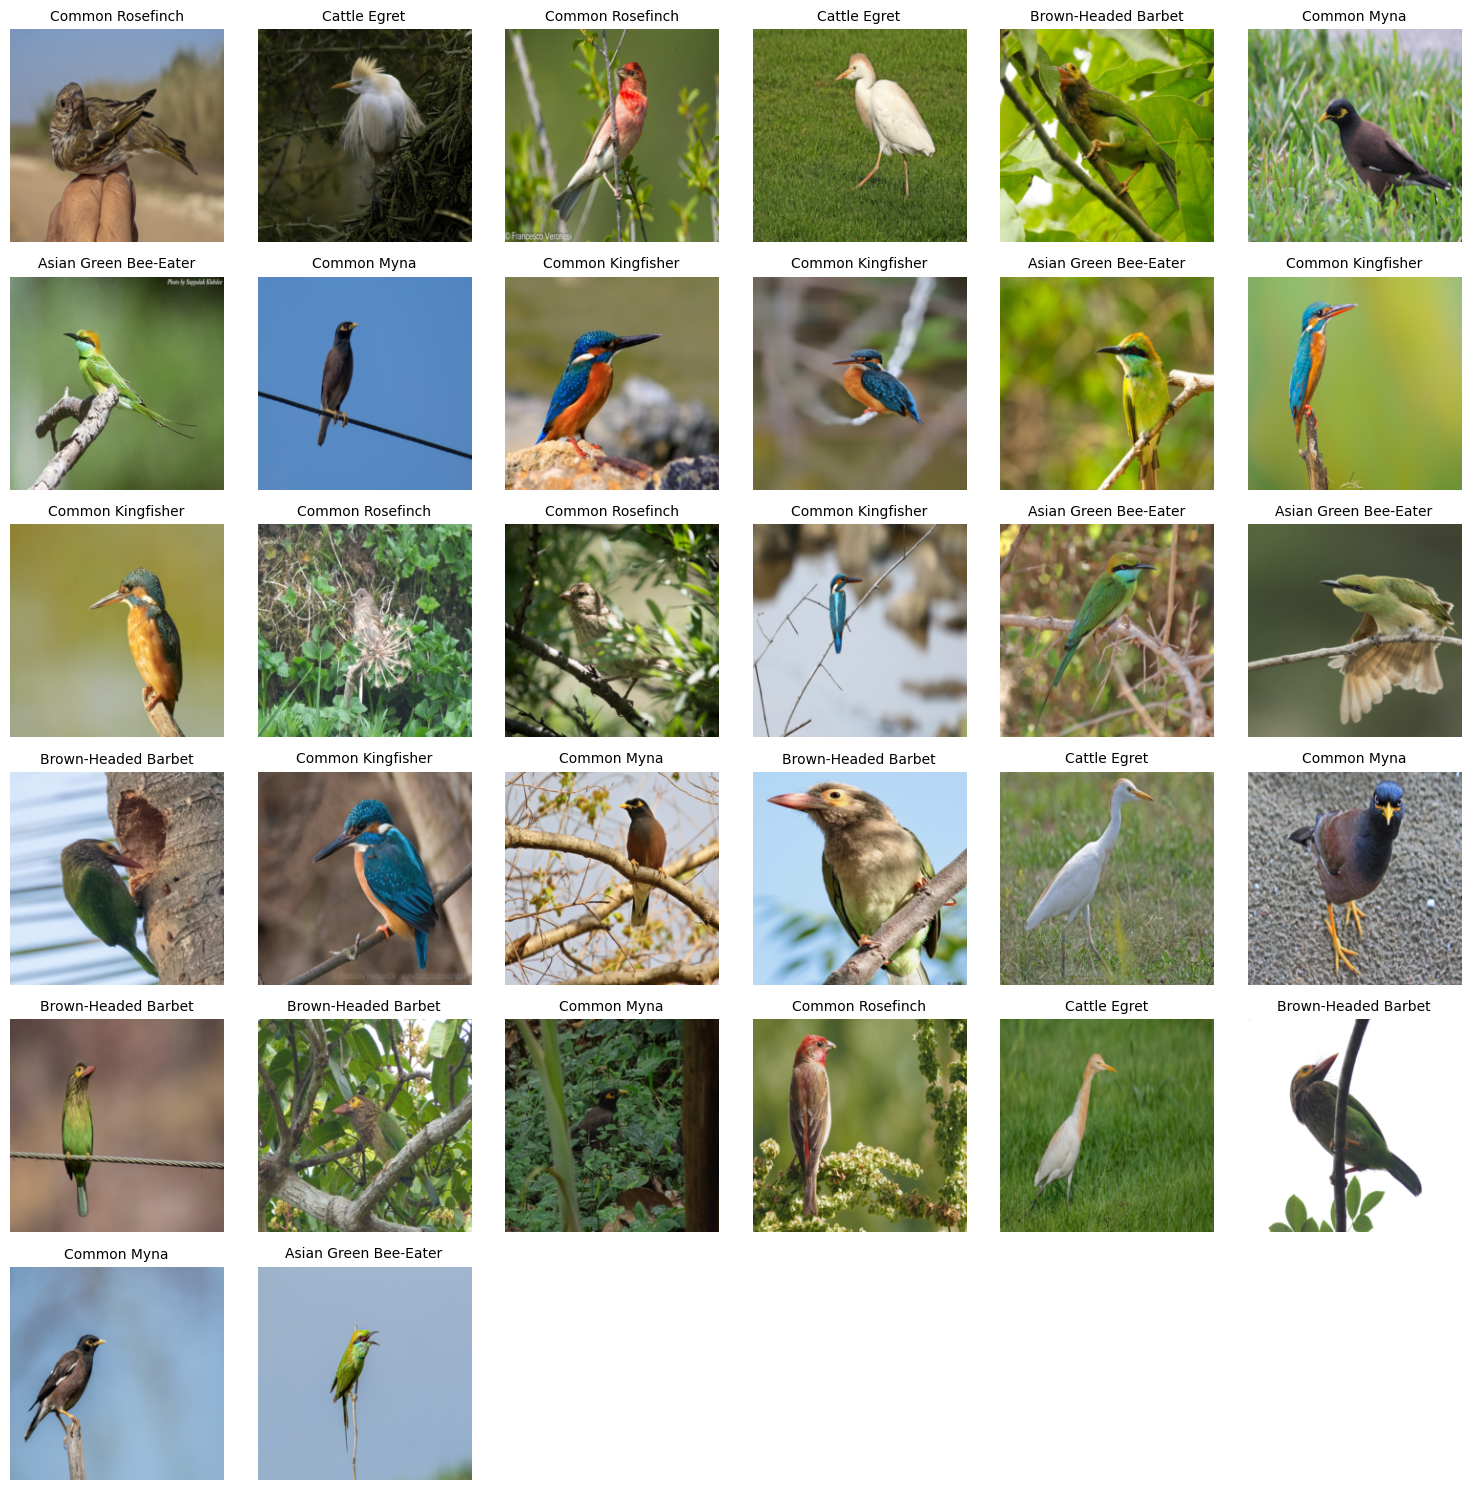

In [4]:
# Utility function to display an image with a caption (label)
def imshow(img_tensor, ax, label):
    """ Utility function to display an image tensor with a caption. """
    # Check if it's an RGB image (3 channels) or grayscale (1 channel)
    if img_tensor.shape[0] == 3:
        ax.imshow(img_tensor.permute(1, 2, 0))  # Reorder dimensions to (H, W, C)
    else:
        ax.imshow(img_tensor[0], cmap='gray')  # Show grayscale images
    ax.axis('off')
    ax.set_title(label, fontsize=10)

# Function to display a batch of images with their corresponding labels
def show_images_batch(images_batch, labels):
    """
    Display a batch of images in a grid with labels.
    """
    batch_size = images_batch.shape[0]
    grid_cols = int(np.ceil(np.sqrt(batch_size)))
    grid_rows = int(np.ceil(batch_size / grid_cols))  # Ensure all images fit in the grid

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 2.5, grid_rows * 2.5))
    if grid_rows * grid_cols == 1:  # Special case for single image
        axes = [axes]  # Make it iterable

    # Ensure axes are iterable
    axes = axes.flatten() if isinstance(axes, np.ndarray) else np.array([axes])

    # Display each image with its corresponding label
    for i in range(grid_rows * grid_cols):
        ax = axes[i]
        if i < batch_size:
            # Use the class name for the label
            label = class_names[labels[i].item()]
            imshow(images_batch[i], ax, label)
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Display a sample batch of images from the training loader
for idx, data in enumerate(train_loader):
    images_batch, labels_batch = data
    show_images_batch(images_batch=images_batch, labels=labels_batch)
    break  # Only show the first batch

# Step 2: Transfer Learning (Using ResNet50)

In [5]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load a pre-trained ResNet50 model
model = models.resnet50(pretrained=True)

# Freeze all layers in the model
for param in model.parameters():
    param.requires_grad = False

for p in model.named_parameters():
    if 'layer4' in p[0]:
        p[1].requires_grad = True

# Replace the final fully connected layer to match the number of classes in your dataset
num_classes = len(class_names)  # Number of categories
model.fc = nn.Linear(2048, num_classes)  # ResNet50 has 2048 output features before the final FC layer

# Unfreeze the last layer for fine-tuning
for param in model.fc.parameters():
    param.requires_grad = True

# Move the model to the appropriate device (GPU or CPU)
model = model.to(device)

e:\anaconda3\envs\python_3_10_14\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\anaconda3\envs\python_3_10_14\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Step 3: Model Training, Evaluation, and Data Augmentation

In [6]:
from torchvision import transforms
from torchsummary import summary

summary(model, (3, WIDTH, HEIGHT))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [8]:
# Data augmentation for the training set
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(WIDTH),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

train_dataset.dataset.transform = train_transform

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Updated training function to include validation
def train_model_with_validation(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training phase
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for val_inputs, val_labels in test_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss_item = criterion(val_outputs, val_labels)
                running_val_loss += val_loss_item.item() * val_inputs.size(0)
                
                _, val_predicted = torch.max(val_outputs, 1)
                total_val += val_labels.size(0)
                correct_val += (val_predicted == val_labels).sum().item()
        
        epoch_val_loss = running_val_loss / len(test_loader.dataset)
        epoch_val_acc = correct_val / total_val
        val_loss.append(epoch_val_loss)
        val_acc.append(epoch_val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')
    
    return train_loss, train_acc, val_loss, val_acc

# Call the updated training function
train_loss, train_acc, val_loss, val_acc = train_model_with_validation(model, train_loader, test_loader, criterion, optimizer, EPOCHS)

Epoch [1/10], Train Loss: 0.7075, Train Acc: 0.7794, Val Loss: 0.3888, Val Acc: 0.8817
Epoch [2/10], Train Loss: 0.3974, Train Acc: 0.8740, Val Loss: 0.3353, Val Acc: 0.8907
Epoch [3/10], Train Loss: 0.3481, Train Acc: 0.8803, Val Loss: 0.3517, Val Acc: 0.8817
Epoch [4/10], Train Loss: 0.3268, Train Acc: 0.8914, Val Loss: 0.3052, Val Acc: 0.8862
Epoch [5/10], Train Loss: 0.3269, Train Acc: 0.8844, Val Loss: 0.2577, Val Acc: 0.9079
Epoch [6/10], Train Loss: 0.3080, Train Acc: 0.8898, Val Loss: 0.3050, Val Acc: 0.8880
Epoch [7/10], Train Loss: 0.3075, Train Acc: 0.8941, Val Loss: 0.2918, Val Acc: 0.8988
Epoch [8/10], Train Loss: 0.3083, Train Acc: 0.8934, Val Loss: 0.2598, Val Acc: 0.9133
Epoch [9/10], Train Loss: 0.3026, Train Acc: 0.8970, Val Loss: 0.3113, Val Acc: 0.8997
Epoch [10/10], Train Loss: 0.3165, Train Acc: 0.8925, Val Loss: 0.2636, Val Acc: 0.9033


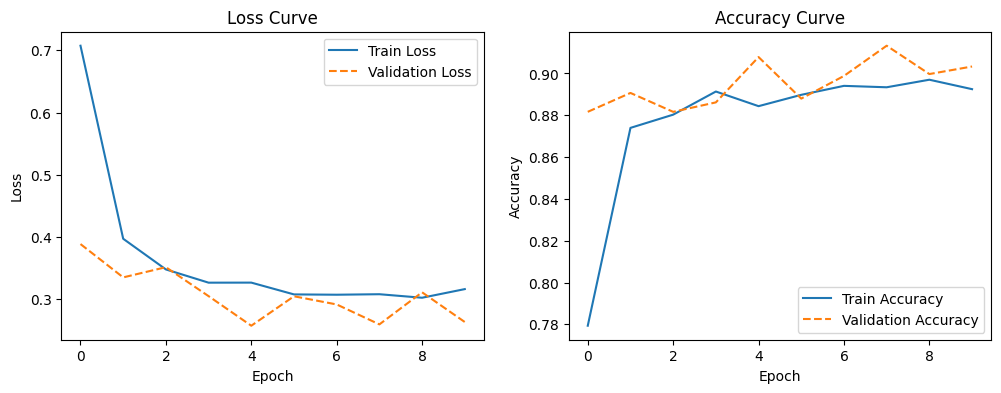

In [9]:
# Plotting training and validation loss/accuracy curves
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss', linestyle='--')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy', linestyle='--')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Save the model and Prediction

In [10]:
# Save the model
model_path = './resnet50_finetuned.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to ./resnet50_finetuned.pth


In [11]:
# Function to load the model
def load_model(model_path, num_classes):
    # Load the pre-trained ResNet50 model
    model = models.resnet50(pretrained=False)  # Use pretrained=False since we are loading custom weights

    # Replace the final fully connected layer to match the number of classes in your dataset
    model.fc = nn.Linear(2048, num_classes)

    # Load the trained weights
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode
    return model

# Load the saved model
loaded_model = load_model(model_path, num_classes)

e:\anaconda3\envs\python_3_10_14\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\anaconda3\envs\python_3_10_14\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\tongt\AppData\Local\Temp\ipykernel_123820\2625175518.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_on

In [21]:
# Function to preprocess and predict on a single image
def predict_image(image_path, model, class_names):
    # Load the image
    image = Image.open(image_path)
    
    # Define the same transforms used during training (resize and to tensor)
    transform = transforms.Compose([
        transforms.Resize((WIDTH, HEIGHT)),
        transforms.ToTensor(),
    ])
    
    # Apply the transformations
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    
    # Move the tensor to the device
    image_tensor = image_tensor.to(device)
    
    # Make the prediction
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
        predicted_class = class_names[predicted.item()]
    
    print(f"Predicted class: {predicted_class}")
    return predicted_class

# Example usage: Predict a class for a single image
# image_path = './Testing/greenbeeeater.jpg'
# image_path = './Testing/brown-headed barbet.jpeg'
# image_path = './Testing/cattle egret.jpeg'
# image_path = './Testing/common kingfisher.jpeg'
# image_path = './Testing/common myna.jpeg'
image_path = './Testing/common rosefinch.jpg'
predicted_class = predict_image(image_path, loaded_model, class_names)

Predicted class: Common Rosefinch
